In [2]:
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_deepseek import ChatDeepSeek
from langgraph.graph import END, START, StateGraph

In [3]:
import sys

sys.path.append("../../")

load_dotenv("../.env")

from api.core.config import settings

print(settings.LLM_HOST)

http://localhost:8090


In [4]:
llm = ChatDeepSeek(
    api_base=f"http://localhost:8090/v1",
    api_key="sk-no-key-required",
    model="deepseek-coder:latest",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


In [5]:
from typing import Annotated

from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]
    file_id: str | None = None
    dataframe: dict

In [6]:
from api.dependencies import get_db
from api.models import User
from api.modules.file_storage.service import FileStorageService
from api.modules.graph_agent.agents.excel_agent.nodes.chatbot import ChatBotNode
from api.modules.graph_agent.agents.excel_agent.nodes.convert_to_dataframe import (
    ConvertToDataFrameNode,
)
from api.modules.graph_agent.agents.excel_agent.nodes.file_router import FileRouterNode
from api.modules.graph_agent.agents.excel_agent.nodes.file_select import FileSelectNode

session = next(get_db())
user = session.get(User, "b51e6baf-359a-482b-8d80-525a700bd5fd")
file_service = FileStorageService()

chatbot = ChatBotNode()
file_router = FileRouterNode()
file_select = FileSelectNode()

convert_to_dataframe = ConvertToDataFrameNode(
    services={"user": user, "session": session, "file_storage": file_service}
)

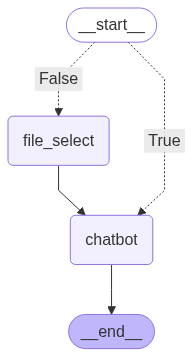

In [7]:
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)

graph_builder.add_node("file_select", file_select)
graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_node("convert_to_dataframe", convert_to_dataframe)

graph_builder.add_conditional_edges(
    START, file_router, {True: "chatbot", False: "file_select"}
)
graph_builder.add_edge("file_select", "chatbot")
# graph_builder.add_edge("convert_to_dataframe", "chatbot")
graph_builder.add_edge("chatbot", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
from uuid import uuid4

thread_id = uuid4()
print("Thread ID: \t", thread_id)

config = {"configurable": {"thread_id": thread_id}}


def print_state():
    state = graph.get_state(config)
    print("> STATE:\n", state.next)
    checkpt = memory.get(config=config)
    print("> MEMORY:\n", checkpt)
    print("#" * 20)


print_state()


events = graph.stream(
    {"messages": [{"role": "user", "content": "Hi"}]},
    config,
    stream_mode="updates",
)

for event in events:
    for node, event_value in event.items():
        print(f"> NODE: '{node}'")


print_state()


Thread ID: 	 eb16597d-6881-42b9-b9ef-0dbef75e07dd
> STATE:
 ()
> MEMORY:
 None
####################

 FLE SMS:
 [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='54f73d4b-aba2-4bf0-96b6-f1374c012db6')]
>> NO FILE, start Interrupt
> NODE: '__interrupt__'
> STATE:
 ('file_select',)
> MEMORY:
 {'v': 2, 'ts': '2025-05-31T07:04:09.242314+00:00', 'id': '1f03ded7-2e1b-6440-8000-93f2d9c2eaca', 'channel_versions': {'__start__': '00000000000000000000000000000002.0.8493491295574896', 'messages': '00000000000000000000000000000002.0.8320024613118923', 'branch:__start__:condition:file_select': '00000000000000000000000000000002.0.9685252926602569'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000001.0.5559642999741177'}}, 'channel_values': {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='54f73d4b-aba2-4bf0-96b6-f1374c012db6')], 'branch:__start__:condition:file_select': '__start__'}, 'pending

In [9]:
from langgraph.types import Command

print("Thread ID: \t", thread_id)

print_state()

events = graph.stream(
    Command(resume="41b233bc-615e-4078-9f87-6f7cfee34fd5"),
    config,
    stream_mode="updates",
)

print_state()

for event in events:
    for node, event_value in event.items():
        print(f"> NODE: '{node}'")
        # if len(event_value.get("messages", [])) > 0:
        #     print(event_value.get("messages")[-1].pretty_print())


print_state()


Thread ID: 	 eb16597d-6881-42b9-b9ef-0dbef75e07dd
> STATE:
 ('file_select',)
> MEMORY:
 {'v': 2, 'ts': '2025-05-31T07:04:09.242314+00:00', 'id': '1f03ded7-2e1b-6440-8000-93f2d9c2eaca', 'channel_versions': {'__start__': '00000000000000000000000000000002.0.8493491295574896', 'messages': '00000000000000000000000000000002.0.8320024613118923', 'branch:__start__:condition:file_select': '00000000000000000000000000000002.0.9685252926602569'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000001.0.5559642999741177'}}, 'channel_values': {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='54f73d4b-aba2-4bf0-96b6-f1374c012db6')], 'branch:__start__:condition:file_select': '__start__'}, 'pending_sends': []}
####################
> STATE:
 ('file_select',)
> MEMORY:
 {'v': 2, 'ts': '2025-05-31T07:04:09.242314+00:00', 'id': '1f03ded7-2e1b-6440-8000-93f2d9c2eaca', 'channel_versions': {'__start__': '00000000000000000000000000